<a href="https://colab.research.google.com/github/mcoudreau/Python/blob/Master/Coudreau_Manon_10_Detection_faux_billets_022023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONTEXTE ET OBJECTIF**

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM souhaite renforcer ses méthodes d’identification des contrefaçons des billets en euros et pour cela nous confie la mission :



1.   De mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.
2.    L’algorithme doit pouvoir différencier les vrais des faux billets à partir des caractéristique géométriques de ces derniers


# **I. Importation des librairies et des données**

In [93]:
import pandas as pd
import numpy as np

# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import statsmodels


# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

# Pour la regression logistique:
from sklearn.linear_model import LogisticRegression

# Pour Kmeans
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
dataset = pd.read_csv('/content/billets.csv',sep = ';')
billets = dataset.copy()
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


6 dimensions géométriques sur un billet



*   length : la longueur du billet (en mm)
*  height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm)
*   height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
*  margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
*   margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm)
*  diagonal : la diagonale du billet (en mm)


# **II. Phase d'exploration des données**
L'objectif de l'exploration :


*   Comprendre nos données
*   Développer une premiere stratégie de modélisation






1.  Exploration



In [3]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
billets.shape

(1500, 7)

In [5]:
# vérifier les valeurs que prend la colonne is_genuine
billets['is_genuine'].unique()

array([ True, False])

In [6]:
# Encoder la variable is_genuine pour avoir que des variables numériques 
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54




*   0 = faux
*   1 = vrai


In [7]:
# afficher les moyennes de variables
billets.mean()

is_genuine        0.666667
diagonal        171.958440
height_left     104.029533
height_right    103.920307
margin_low        4.485967
margin_up         3.151473
length          112.678500
dtype: float64


2.   Exploration des valeurs aberrantes/atypiques de la variable margin_up



In [8]:
# Vérification des valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 valeurs manquantes pour la variable margin_low

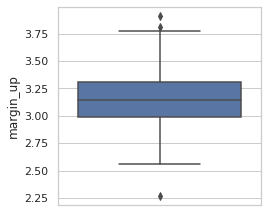

In [9]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')

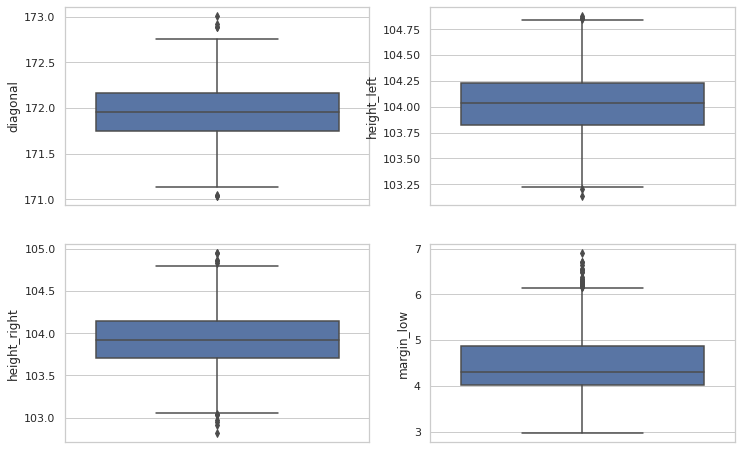

In [10]:
# Afficher des boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low')

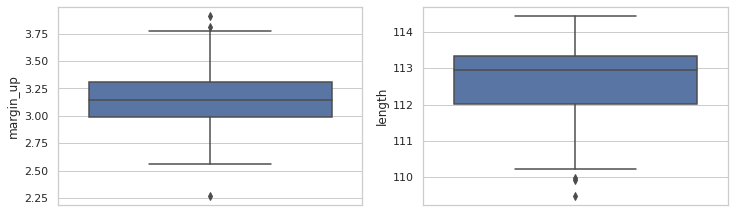

In [11]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')
plt.subplot(222)
sns.boxplot(data=billets,  y='length')


3.   Exploration de la matrice des correlations



In [12]:
# Afficher la matrice de corrélation
matrice_correlation = billets.corr()
matrice_correlation.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


Text(0.5, 1.0, 'Corrélation entre les différentes variables')

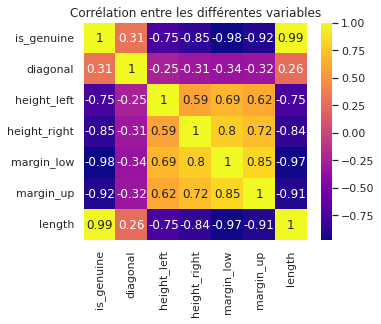

In [13]:
# heatmap de corrélations entre les différentes variables
plt.figure(figsize=(5, 4))
sns.heatmap(matrice_correlation.corr(),cmap='plasma', annot=True)
plt.title('Corrélation entre les différentes variables')

In [14]:
billets.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Text(0.5, 1.0, 'Taux des vrais et faux billets')

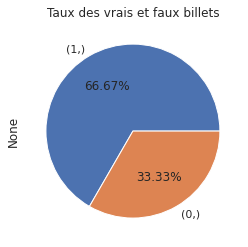

In [15]:
# afficher les taux de faux billets et des vrais billets
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')


CONCLUSION
*   ID : is_genuine
*   Nous avons 1 500 données et 7 colonnes
*   Nous avons 37 données nulles
*   Nous avons 6 variables quantitatives et 1 variable qualitative







Il y a des données manquantes, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.

# **III. Regression linéaire : combler les valeurs manquantes**
Nous allons créer deuxx DF : 
*   Dataset training : un DF avec sans valeur manquantes que nous utiliserons pour notre régression liniéaire
*   Dataset testing :  un dataframe avec uniquement les valeurs manquantes pour appliquer notre modèle






1.   Création de deux DF



In [16]:
# dataset sans les valeurs manquantes
df_training  = billets.dropna()
df_training.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [17]:
# dataset avec les valeurs manquantes
df_testing = billets.loc[billets['margin_low'].isnull(),['is_genuine','diagonal','height_left','height_right','margin_up','length']]
df_testing.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36




1.   OLS - Regression linéaire backward



In [21]:
# régresseur de manière itérative : backwards > nous supprimons des variables petit à petit 
import statsmodels.formula.api as smf

#Lancer une regression sur le marge 
reg_multi = smf.ols('margin_low~diagonal+length+height_left+is_genuine+margin_up+height_right', data=df_training).fit()

print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          4.75e-299
Time:                        13:59:37   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

In [22]:
#https://stackoverflow.com/questions/38905031/name-classification-model-is-not-defined
#Fonction de selection automatique du modele
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model
        
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
regression_backward = backward_selected(df_training[columns], 'margin_low')

_______________________________
margin_low ~ height_right + diagonal + margin_up + is_genuine + length + height_left + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_right + diagonal + margin_up + is_genuine + height_left + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_right + margin_up + is_genuine + height_left + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ margin_up + is_genuine + height_left + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

In [23]:
# régresseur de manière itérative : backwards > nous supprimons des variables petit à petit 
import statsmodels.formula.api as smf

#Lancer une regression sur le marge 
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df_training).fit()

print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          1.24e-304
Time:                        13:59:37   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0



2.   Explorer les outliers de la variable margin_up puis nous les supprimons




,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


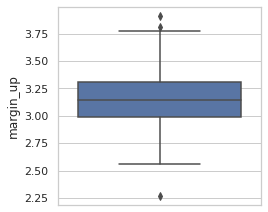

In [24]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')

df_training = df_training.loc[(df_training['margin_up']>2.40) & (df_training['margin_up']<3.75)]
df_training

In [29]:
df_training_vf = df_training.drop(['diagonal','length','height_right','height_left'],axis=1)
df_training_vf.head()

,is_genuine,margin_low,margin_up
0,1,4.52,2.89
1,1,3.77,2.99
2,1,4.40,2.94
3,1,3.62,3.01
4,1,4.04,3.48




3.   Nous faisons une régression linéaire (OLS) sur les deux variables que nous souhaitons conserver




In [31]:
reg_multi_lin = smf.ols('margin_low~+is_genuine+margin_up ', data=df_training_vf).fit()
print(reg_multi_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1173.
Date:                Thu, 23 Feb 2023   Prob (F-statistic):          6.00e-304
Time:                        14:18:22   Log-Likelihood:                -765.65
No. Observations:                1456   AIC:                             1537.
Df Residuals:                    1453   BIC:                             1553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9157      0.200     29.550      0.0

# **IV. Modélisation**


Construire le df final avec les valeurs manquantes prédites


In [34]:
prediction = df_testing.drop(['diagonal','height_left','height_right','length'],axis=1)

valeurs_pred = reg_multi_lin.predict(prediction)
df_testing['margin_low_pred'] = valeurs_pred

In [35]:
df_final = billets.copy()
df_final.loc[df_testing.index, 'margin_low'] = df_testing['margin_low_pred']
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [36]:
df_final.shape

(1500, 7)

In [37]:
df_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [38]:
df_final.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482836,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659845,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


# **V. Résidus**

In [42]:
x_test = df_training_vf.loc[:,['is_genuine','margin_up']]
y_test = df_training['margin_low']

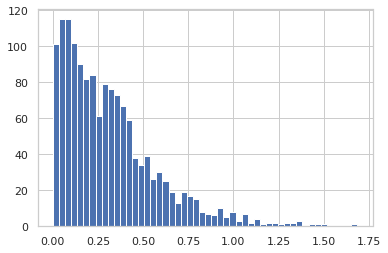

In [43]:
# Représentation de nos erreurs avec un histogramme
y_pred=reg_multi.predict(x_test)
erreur_hi=np.abs(y_test-y_pred)
plt.hist(erreur_hi,bins=50)
plt.show()

Vérifier la normalités des résidus 

In [44]:
# Moyenne des résidus
moy_residus = y_test-y_pred
moy_residus .mean()

-0.0011155835228046863

-0.0011155835228047009 étant proche de 0, nous pouvons considérer que cette hypothèse est validée.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


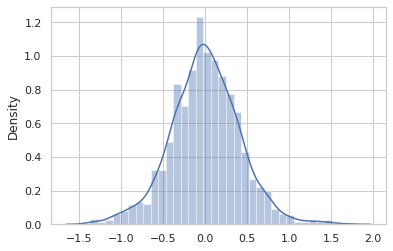

In [45]:
sns.distplot(moy_residus)

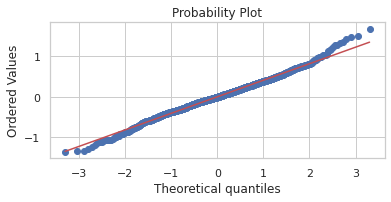

In [46]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(moy_residus, plot=ax, fit=True)




*   Vérifier la colinéarité des variables


Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [47]:
variables = reg_multi_lin.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.586122883225347, 1.586122883225347]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

In [48]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_lin.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.321149750524877e-36


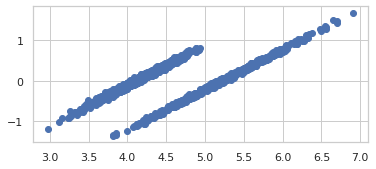

In [49]:
fig, ax = plt.subplots(figsize=(6,2.5))
_= ax.scatter(y_test,moy_residus)




*   Déterminez la distance de Cook


Pour trouver la distance de Cook, nous exécutons ceci :

In [50]:
influence = reg_multi_lin.get_influence().summary_frame()

In [57]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 7/(n-p)

NameError: ignored

On peut détecter les observations influentes comme ceci :

In [52]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 115, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 115], [seuil_dcook, seuil_dcook], color='r')
plt.show()

NameError: ignored

<Figure size 720x432 with 0 Axes>

# **VI. Evaluation du modèle**

# **a) Régression  Logistique - Classification**

L'objectif d'une régression logistique est de créer un modèle prédictif. 
Nous souhaitons expliquer une variable qualitative (vrai/faux) par des données quantitatives = regression logistique.
Nous devons donc isoler les données quantitatives et qualitatives. 


In [ ]:
# Données qualitatives
y = df_final.loc[:, df_final.columns == "is_genuine"]
print(y.value_counts())

# Données quantitatives
#Il faut ajouter une constante dans Statsmodels
x = df_final.loc[:, df_final.columns != "is_genuine"]
x = sm.tools.add_constant(x)                      
print(x.head())

In [100]:
# on ajuste le modèle
model = sm.Logit(y, x)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                  0.9586
Time:                        15:35:01   Log-Likelihood:                -39.487
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -231.2872    249.976     -0.925      0.355    -721.231     258.657
diagonal         0.268

Il y a des variables non-significatives au seuil alpha 5%.
Nous pouvons recommencer la régression logistique sans les variables: diagonal, height_left, height_right.


In [105]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
x2 = df_final[["height_right","margin_low", "margin_up", "length"]]
x2 = sm.add_constant(df_final)

# On recommence la regression logistique:
reg_log = sm.Logit(y, x2)
result2 = model.fit()

# Resume des resultats:
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.959   
Dependent Variable:   is_genuine       AIC:              92.9738 
Date:                 2023-02-23 15:51 BIC:              130.1664
No. Observations:     1500             Log-Likelihood:   -39.487 
Df Model:             6                LL-Null:          -954.77 
Df Residuals:         1493             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -231.2872 249.9759 -0.9252 0.3548 -721.2311 258.6566
diagonal        0.2683   1.1369  0.2360 0.8134   -1.9600   2.4965

# **b) K-NN**

In [129]:
import numpy as np

sample = np.random.randint(70000, size=5000)
data = df_training.drop("margin_low", axis=1)
target = df_training["margin_low"]

In [114]:
# Creation de x_train et y_train pour spliter le df (80% et 20%):
x_train = df_training.drop("margin_low", axis=1)
y_train = df_training["margin_low"]

In [140]:
x_train, x_test, y_train, y_test = train_test_split(df_final.drop(["is_genuine"],axis=1), df_final[["is_genuine"]], test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1200, 6)
(300, 6)
(1200, 1)
(300, 1)


In [137]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [138]:
error = 1 - knn.score(x_test, y_test)
print('Erreur: %f' % error)

Erreur: 0.006667


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

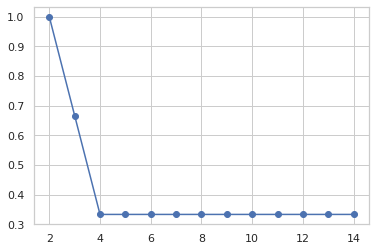

In [139]:
# Optimisation du score sur les données test
import matplotlib.pyplot as plt

errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(x_train,y_train).score(x_test,y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

Comme on peut le voir, le k-NN le plus performant est celui pour lequel k = 4. On connaît donc notre classifieur final optimal : 4-nn. Ce qui veut dire que c'est celui qui classifie le mieux les données, et qui donc dans ce cas précis reconnaît au mieux les nombres écrits à la main.:

In [141]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(4)
knn.fit(x_train, y_train)

# On récupère les prédictions sur les données test
predicted = knn.predict(x_test)

for index, value in enumerate(select):
    plt.subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow(images[value],cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format( predicted[value]) )

plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


TypeError: ignored

# **c) K-Means**

In [79]:
kmeans = df_final.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [82]:
# Selectionner les valeurs à utiliser pour notre analyse
X = kmeans.values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Utilisation de la methode "ward"
Z = linkage(X_scaled, method="ward")
Z[:2]

array([[3.61000000e+02, 9.04000000e+02, 1.69310141e-01, 2.00000000e+00],
       [1.27000000e+02, 7.35000000e+02, 1.84326824e-01, 2.00000000e+00]])

In [81]:
#On applique ensuite la fonction fclusters de scipypour définir les clusters :
#Identification des 7 groupes obtenus
clusters = fcluster(Z, 2, criterion='maxclust')
clusters

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [ ]:
inertia = []
k_range=range(1,10)
for k in k_range:
    modelkm=KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(modelkm.inertia_)
   
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie')
plt.grid() 
plt.show()
print('Inertie totale :',modelkm.inertia_)

In [ ]:
%pylab inline
from sklearn import cluster, metrics

silhouettes = []

for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters = num_clusters,
                         n_init=1, init="random")
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2,10), silhouettes, marker='o')

In [85]:
from sklearn import cluster, metrics
# Nous déffinissons 2 clusters pour notre modèle et entrainons le sur le jeu d'entrainement
model_km = KMeans(n_clusters=2)
km=model_km.fit(X_scaled)
km.predict(X_scaled)

# évaluer avec le jeu de test
h=km.predict(X_scaled)

# inverser les valeur tel que vrai billet=1 et faux billet=0
a = 1-h
#ypred.inertia_
print('Inertie totale :',km.inertia_)

Inertie totale : 5801.798628796437


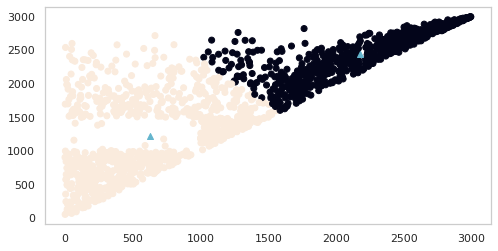

Inertie totale : 672602643.0401471


In [86]:
fig = plt.figure(figsize=(8,4))
model = KMeans(n_clusters=2)
model.fit(Z)
model.predict(Z)
plt.scatter(Z[:,0], Z[:,1],c=model.predict(Z))
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='^',c='c')
plt.grid()
plt.show()
print('Inertie totale :',model.inertia_)

In [109]:
# Nous affichons les billets vrais positifs, billets faux positifs, billets vrais négatifs et les billets faux négatifs
vraipos, vraineg, fauxneg, fauxpos = confusion_matrix(df_final['is_genuine'],a).ravel()
vraipos, vraineg, fauxneg, fauxpos
print("\n"'Vrais positifs :',vraipos,"\n"'Faux positifs :',fauxpos,"\n"'Vrais négatifs :',vraineg,"\n"'Faux négatifs :',fauxneg)


Vrais positifs : 486 
Faux positifs : 990 
Vrais négatifs : 14 
Faux négatifs : 10


# **d) La courbe de ROC**

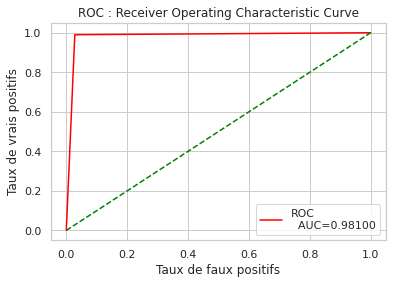

In [112]:
def plot_roc_curve(fauxpos, vraineg):
    aucf =metrics.auc(fauxpos, vraineg)
    plt.plot(fauxpos, vraineg, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('ROC : Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = km.predict(X_scaled)
#prob = probs[:, 1]
fauxpos, vraineg, thresholds = roc_curve(df_final['is_genuine'], a)
plot_roc_curve(fauxpos, vraineg)